# Data analysis: individual fairness for SMI

This notebook contains all the code necessary for runing the data analysis for the paper "The role of luck in the success of social media influencers" (Applied Network Science, 2023). As mentioned in the ReadMe file of our GitHub repository, running this code requires generatig the data first. More precisely, it assumes the existance of 20k config and run files within a folder named Simulation_results. If this is not the case, please return to the ReadMe file for instructions on how to generate them. 

We first import the needed libraries. You might need to install them if you did not already.

In [1]:
import simulation as sim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import ast

import math

The function below creates a list with the simulation results. The default parameters assume you want to start with the parameters given by 'cofig0.csv' and that the files can be found within the folder titled 'Simulation_results'.

In [2]:
def read_sims(no, first_sim=0, path='Simulation_results/'):
    '''Constructs simulations for no many previously run ones.
    
    Input
    ------
    no: int
       The number of config files to load
    first_sim: int
       The first config number which should be loaded
    pat: string
       The folder where the config and run files are
    ------
    
    Output
    ------
    all_sims: list
        A list of Simulations objects which have config file loaded (but, for better runtime, not the results)
    ------
    '''

    # start with an empty list
    all_sims = []
    
    # loop over config numbers in the specified range
    for n in range(first_sim, first_sim + no):
        # build the Simulation object for the config with that number
        s = sim.Simulation(path + 'config' + str(n) + '.csv')
        
        # read the config file values (to save time, we only read the results of a simulation when needed)
        s.read(False)
        
        # add the Simulation object to our list
        all_sims.append(s)

    return all_sims

In [3]:
# read the config data
sims = read_sims(20000)

## Auxiliary functions 

First we define a function that based on the list with the number of followers for content creators orderd from best-quality (position 0) to lowest-quality (last position) returns the same-size binary list. More precisely, the list will have on each position 0 if the input popularity list does is not individually fair for the respective content creator. Similarly, 1 will be used to signal individual fairness for the respective content creator.

In [4]:
def get_if_IF(popularity):
    '''Given a list of follower counts for content creators in the order of their 
    quality finds if each is treated fairly.
    
    Input
    ------
    popularity: list
       List of nonegative integers corresponding to follower counts for each creator
    ------
    
    Output
    ------
    is_fair: list
        A list of 0/1 of the same length as the input.
    ------   
    '''
    
    num_CCs = len(popularity)

    # get the inexes of CCs by the number of followers
    popularity = np.array(popularity)
    ordered_by_popualrity = np.flip(popularity.argsort())
    id_to_position_popualrity = {i:pos for pos, i in enumerate(ordered_by_popualrity)}
    # print(ordered_by_popualrity)

    # find if fair (CC_i is in terms of popularity on the position it deserves or more twoards the top)
    def is_fair(i):
        return int(id_to_position_popualrity[i] <= i)
    
    return [is_fair(i) for i in range(num_CCs)]

Next, we define a function which selects only the parameters and simulation results that are needed for the plots to follow. The selected data is added to a dataframe compatible with seaborn. The input signals the type of plot to follow. 

In [5]:
def data_IF(all_sims, fixed_pars = {}, x="CCs", y="num_followers", hue = "alpha", style = None,
                            measure_at_time = 0, print_progress = True):
    '''
    Creates a dataframe with a selection of simulation results corresponding to the specifeid input data.
    
    Input
    ------
    all_sims: list
       The list of Simulation objects (with config file loaded)
    fixed_pars: dict
       A dictionary which maps parameter names with list of values thay can take; 
       only the simulations with specified pararameters having values withint this list will be included in the final dataframe
    x: string
        Parameter name for the x-axis of the plot to follow
    y: string
        Parameter name for the y-axis of the plot to follow
    hue: string
        Parameter name for the hue which will be used in the plot to follow
    style: None/'timestep'
        Will be used to signal whether the results should be recorded at all intermediate timesteps ('timesteps') 
        or only at final ones (None)
    measure_at_time: int
        Specified the timestep to be considered
    print_progres: bool
        Says whether or not the progress in loading the simulation results should be shown
    ------
    
    Output
    ------
    data: dataframe
        Includes the selected results and configs for the specified parameters
    ------
    '''
    
    # Create a label for the y-axis (which will contain averages of y-values resulted from multiple simulations)
    y_label = 'average_' + y
    
    # Create the dictionary from which we will form the dataframe
    d = {x:[], y_label:[], hue:[]}
    if style:
        d[style] = []
    
    # We consider the results of each run in turn and add them to the dictionary 
    for s_num, s in enumerate(all_sims):
        
        # Print progress every 1k steps if needed
        if s_num%1000 == 0 and print_progress:
            print(s_num)
        
        # Check whether the curent simulation has the parameter configuration as specified by fixed_pars
        #    if so, it will be added further considered, otherwise it will be ingored
        have = True
        for p in fixed_pars:
            if p in s.config:
                if str(s.config[p]) not in fixed_pars[p]:
                    have = False
        
        # If the simulation s corresponds we proceed to integrate it into the dictionary d
        if have:
            # load the results for simulation s
            results = s.return_results()
            
            # if we want to find the %of CC who have IF, results[y] need to be computed
            # otherwise the results[y] already exists and we load it at the specified timestep
            if y == 'CC_is_IF':
                if style is None:
                    results[y] = get_if_IF(results['num_followers'][measure_at_time])
                else:
                    results[y] = [get_if_IF(results['num_followers'][i]) 
                                  for i, t in enumerate(s.config['record_at_timesteps'])]
            else:
                results[y_label] = results[y][measure_at_time]
            
            # we consider four cases of plots:
            #     (1) when we record the results at different timesteps
            #     (2) when results are at one specific timestep (e.g., quality vs IF)
            #     (3) when we look at whether the simulation converged
            #     (4) when we look at user satisfaction
            if style is not None:
                for i, t in enumerate(s.config['record_at_timesteps']):
                    for c in range(s.config['num_CCs']):
                        d[hue].append(s.config[hue])
                        d[style].append(t)
                        d[x].append(c)
                        d[y_label].append(results[y][i][c])
            elif x == "CCs":
                for c in range(s.config['num_CCs']):
                    d[hue].append(s.config[hue])
                    d[x].append(c)
                    d[y_label].append(results[y][c])
            elif x == "timestep" and y=="did_converge":
                for i, t in enumerate(s.config['record_at_timesteps']):
                    d[hue].append(s.config[hue])
                    d[x].append(t)
                    d[y_label].append(results[y][i])
            elif x == "timestep":
                # if it converges faster, we keep the results of the last
                max_i = len(results[y_label])
                for i in range(1000):
                    d[hue].append(s.config[hue])
                    d[x].append(i+1)
                    if i<max_i:
                        d[y_label].append(results[y_label][i] + 1)
                    else:
                        d[y_label].append(results[y_label][-1] + 1)
                    
    return pd.DataFrame(data=d)

Finally, we define the collour palette we will use for the plots. 

In [6]:
alpha_list = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
palette = sns.color_palette('PuBu', 10)[1:][::-1]+ ['#D3D3D3']+ sns.color_palette('OrRd', 10)[1:]
palette = {a:palette[i] for i, a in enumerate(alpha_list)}

## The chance of individual fairnes as a function of the quality of content creators 

First, we create the dataframe with the rank of content creators on the column x="CCs" and the IF on the y='CC_is_IF'.

In [7]:
d = data_IF(sims, y = 'CC_is_IF', measure_at_time = -1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


The block below corresponds to the plot provided in the grafical abstract. It shows the procentage of simulations for which the outcome was individual fair as a function of the ranking of content creators. This can also serve as a template on doing similar individual plots.

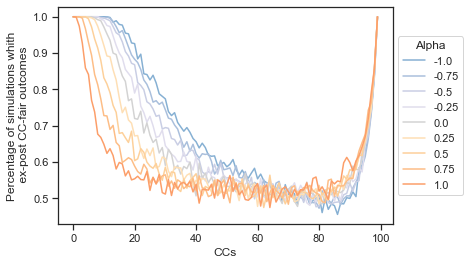

In [8]:
# specify the size and theme of the figure
sns.set(rc={'figure.figsize':(4.2,3.27)})
sns.set_theme(style="ticks")

# select the subset of values of alpha we will plot
alpha_list = [-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
d_aux = d[d['alpha'].isin(alpha_list)]

# make the plot (without confidence intervals and with averages)
ax = sns.lineplot(data=d_aux, x='CCs', y='average_CC_is_IF', ci = None, estimator = np.mean, hue='alpha', 
                 palette = palette, legend = 'full')
ax.set(ylabel='Percentage of simulations whith\n ex-post CC-fair outcomes')

# position legend outside plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Alpha')

# generate the figure (and save it if uncommenting the final line) 
fig = ax.get_figure()
# fig.savefig("IF_abstract.png", dpi = 600, bbox_inches="tight")

The next block provides the code for grouping multiple single plots (as the one above) into a single one with a common legend. It can be used to generate Figures 7 and 11 in the paper, depending on the confidence interval one inputs. You can change it on the second line (switch the value of ci_size to 95 if you want to obtain Fig.11).

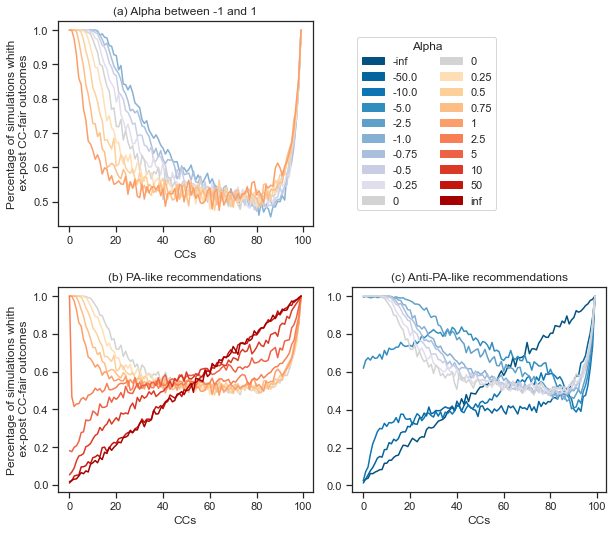

In [9]:
# choose the value of the next paramter (ci_size = None --> Fig. 7; ci_size = 95 --> Fig. 11)
ci_size = None

# specify the size, theme and number of sublots for the figure
sns.set(rc={'figure.figsize':(8.7,7.57)})
sns.set_theme(style="ticks")

fig, axs = plt.subplots(2, 2)

# lists values of alphas for each subplot
alpha_list = []
alpha_list.append([-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
alpha_list.append([0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000])
alpha_list.append([0, -0.25, -0.5, -0.75, -1, -2.5, -5, -10, -50, -1000])

# subtitles for each subplot
titles = ['(a) Alpha between -1 and 1', '(b) PA-like recommendations', '(c) Anti-PA-like recommendations']

# legend to be included at the end
all_alphas = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
alphas_lbl = [-float('inf'), -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, float('inf')]
handles_list = [mpl.patches.Patch(color=palette[a], label=alphas_lbl[i]) for i, a in enumerate(all_alphas)]

# build the sublots
c = -1
for (i, j) in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    if not (i==0 and j==1):
        # Plot subplot_i
        c+=1
        d_aux = d[d['alpha'].isin(alpha_list[c])]
        sns.lineplot(data=d_aux, x='CCs', y='average_CC_is_IF', ci = ci_size, estimator = np.mean, hue='alpha', 
                     palette = palette, legend = 'full', ax=axs[i, j])
    
        # don't show the legend
        axs[i, j].get_legend().remove()
        
        # common y-label
        axs[i, j].set(ylabel='Percentage of simulations whith\n ex-post CC-fair outcomes')
        if (i+j) == 2:
            axs[i, j].set(ylabel=None)
            
        # set title
        axs[i, j].set_title(titles[c])
    else:
        axs[i, j].axis('off')
        axs[i, j].legend(handles=handles_list, loc ='center left', ncol=2, title = 'Alpha')

# generate the figure (and save it if uncommenting the final line)
fig.tight_layout()
# fig.savefig("Figure_7.png", dpi = 600, bbox_inches="tight")

Figures 9 and 12 illustrate the effect of time on the chance of obtaining individually fair outcomes for different content creators. The block immediately below constructs the dataframe with the simulation results needed for the plots. The one after creates one figure with two subplots. As before, changing the 'ci_size' (second line of first block) from 'None' to '95' will move from plotting Figure 9 to plotting Figure 12.

In [10]:
# Create the dataframe for showing the IF at different timesteps
#    fp     -> the values of alpha which we want to plot
fp = {'alpha': ['-10.0', '-5.0', '-2.5', '-1.0', '0', '1', '2.5', '5', '10']}
df_IF_timesteps = data_IF(sims, x = 'CCs', y = 'CC_is_IF', style = 'timestep', fixed_pars = fp)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


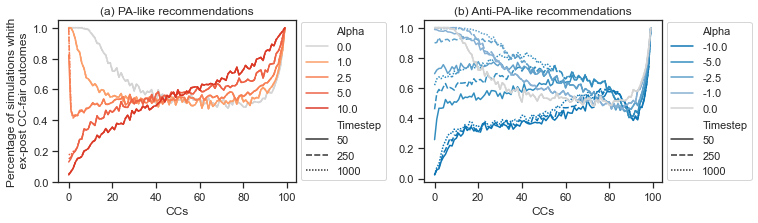

In [11]:
# choose the value of the next paramter (ci_size = None --> Fig. 9; ci_size = 95 --> Fig. 12)
ci_size = None

# specify the size, theme and number of sublots for the figure
sns.set(rc={'figure.figsize':(10.7,3.27)})
sns.set_theme(style="ticks")

fig, axs = plt.subplots(1, 2)

# lists values of alphas for each subplot
alpha_list = []
alpha_list.append([0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000])
alpha_list.append([0, -0.25, -0.5, -0.75, -1, -2.5, -5, -10, -50, -1000])

# subtitles for each subplot
titles = ['(a) PA-like recommendations', '(b) Anti-PA-like recommendations']

# legend to be included at the end
all_alphas = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
handles_list = [mpl.patches.Patch(color=palette[a], label=alphas_lbl[i]) for i, a in enumerate(all_alphas)]

# build the sublots
for i in range(2):
    # Plot subplot_i
    df_aux = df_IF_timesteps[df_IF_timesteps['alpha'].isin(alpha_list[i])]
    df_aux = df_aux[df_aux['timestep'].isin([50, 250, 1000])]
    sns.lineplot(data=df_aux, x='CCs', y='average_CC_is_IF', ci=ci_size, hue='alpha',
                 style = 'timestep', estimator = np.mean, palette = palette, ax=axs[i])
    
    # Arrange legend
    lines_labels = [axs[i].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    labels[0] = 'Alpha'
    labels[6] = 'Timestep'
    axs[i].legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    # Common y label
    if i==0:
        axs[i].set(ylabel='Percentage of simulations whith\n ex-post CC-fair outcomes')
    else:
        axs[i].set(ylabel=None)
    
    # Set title
    axs[i].set_title(titles[i])

# generate the figure (and save it if uncommenting the final line)
fig.tight_layout()
# fig.savefig("IF_at_timesteps_CI95.png", dpi = 600, bbox_inches="tight")

## The fraction of simulations which converged within given timelimits

The next two blocks correspond to Figure 8. First, we create the dataframe containing the timesteps tracked and whether or not each simulation converged at the respective timestep. Second, we create the plot in Figure 8 using this dataframe as a start. As explained in the paper, we exclude alpha values of plus and minus infinity due to fast convergence times for these parameters. Moreover, we exclude some intermediate values of alpha which did not convey additional information. Changing the 'alpha_list' parameter will provide more granularity. Similarly, we only plot a subselection of timesteps. You can enlarge this selection by changing 'selection_timesteps'.

In [12]:
# create dataframe of timesteps and whether or not the simualtion converged at each timestep
df_convergence = data_IF(sims, x = 'timestep', y = 'did_converge')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


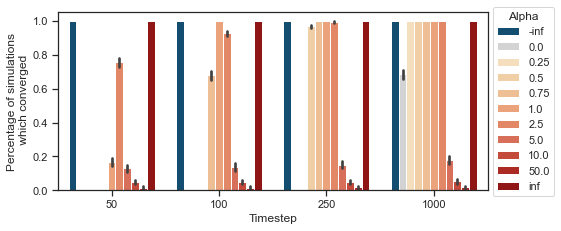

In [13]:
# specify the size, theme and number of sublots for the figure
sns.set(rc={'figure.figsize':(7.7,3.27)})
sns.set_theme(style="ticks")

# choose the values of alpha for which we will make the plots and filter the dataframe to only include those
alpha_list = [-1000, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
df_convergence_aux = df_convergence[df_convergence['alpha'].isin(alpha_list)]

# select a subset of existing timesteps and filter the dataframe to only include those
selection_timesteps = [50, 100, 250, 1000]
df_convergence_aux = df_convergence_aux[df_convergence_aux['timestep'].isin(selection_timesteps)]

# create the barplot
ax = sns.barplot(data=df_convergence_aux, x="timestep", y="average_did_converge", hue="alpha", palette = palette)

# add legend and labels
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels[0] = '-inf'
labels[-1] = 'inf'
ax.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title = 'Alpha')
ax.set(ylabel="Percentage of simulations\n which converged", xlabel='Timestep')

# generate the figure (and save it if uncommenting the final line)
fig = ax.get_figure()
# fig.savefig("convergence.png", dpi = 600, bbox_inches="tight")

## The satisfaction of seekers

Finally we plot the satisfaction of seekers (Figure 10). As before, we the next block of code creates the dataframe which is used by the block after to generate the figure.

In [14]:
# create the dataframe for the satisfaction of users
df_user_satisfaction = data_IF(sims, x = 'timestep', y = 'average_pos_best_CC', measure_at_time = -1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


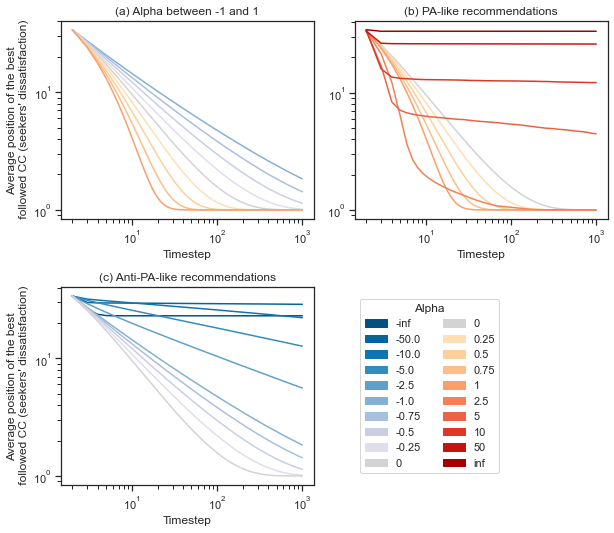

In [15]:
# specify the size, theme and number of sublots for the figure
sns.set(rc={'figure.figsize':(8.7,7.57)})
sns.set_theme(style="ticks")

fig, axs = plt.subplots(2, 2)
#fig.suptitle('CC-fairness for different recommendation processes')

# values of alphas for each subplot
alpha_list = []
alpha_list.append([-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
alpha_list.append([0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000])
alpha_list.append([0, -0.25, -0.5, -0.75, -1, -2.5, -5, -10, -50, -1000])

# subtitles for each subplot
titles = ['(a) Alpha between -1 and 1', '(b) PA-like recommendations', '(c) Anti-PA-like recommendations', 'Legend']

# legend to be included at the end
all_alphas = [-1000, -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
alphas_lbl = [-float('inf'), -50.0, -10.0, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0 , 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, float('inf')]
handles_list = [mpl.patches.Patch(color=palette[a], label=alphas_lbl[i]) for i, a in enumerate(all_alphas)]

# build the sublots
c = -1
for (i, j) in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    c+=1
    if i+j != 2:
    # Plot subplot_i
        df_user_satisfaction_aux = df_user_satisfaction[df_user_satisfaction['alpha'].isin(alpha_list[c])]
        df_user_satisfaction_aux = df_user_satisfaction_aux[df_user_satisfaction_aux['timestep'].isin(range(2, 1005))]
        # df_user_satisfaction_aux = df_user_satisfaction_aux[df_user_satisfaction_aux['did_converge'] == True]
        sns.lineplot(data=df_user_satisfaction_aux, x='timestep', y='average_average_pos_best_CC', ci=None, hue='alpha',
                     estimator = np.mean, palette = palette, legend = 'full', ax=axs[i, j])

        # Logarithmic scale
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
    
    # Show legend only in final plot
    if i+j == 2:
        axs[i, j].axis('off')
        axs[i, j] = plt.legend(handles=handles_list, loc ='center left', ncol=2, title = 'Alpha')
        # axs[i, j].get_frame().set_edgecolor('w')
        # axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, labels = alpha_labels, title = 'Alpha')
    else:
        axs[i, j].get_legend().remove()
    
    # Common y label
    if j==0:
        axs[i, j].set(ylabel="Average position of the best\n followed CC (seekers' dissatisfaction)", xlabel='Timestep')
    elif i+j != 2:
        axs[i, j].set(ylabel=None, xlabel='Timestep')
    
    # Set title
    if i+j != 2:
        axs[i, j].set_title(titles[c])

# generate the figure (and save it if uncommenting the final line)
fig.tight_layout()
# fig.savefig("seeker_sat_mean_test.png", dpi = 600, bbox_inches="tight")

This completes the list of plots within the paper realised with python. Thank you for following through and for engaging with the content of our paper!